# Modeling Lesson

In this lesson, we'll do a bit of feature engineering, and then model our text data. We'll be aiming to predict whether a given text message is spam or not, and trying to predict the category of news articles.

### **Feature Extraction: TF-IDF**  

- **TF**: Term Frequency; how often a word appears in a document.  

- **IDF**: Inverse Documnet Frequency; a measure based on in how many documents will a word appear.  

- **TF-IDF**: A combination of the two measures above.  

<br/>

### **Term Frequency (TF)**  

Term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

- **Raw Count**: This is simply the count of the number of occurances of each word.  

- **Frequency**: The number of times each word appears divided by the total number of words.

- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

Let's take a look at an example:

In [1]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

In [2]:
document = 'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
a,3,0.272727,1.000000
little,3,0.272727,1.000000
lamb,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


### ***TF inputs***

#### The calculation for an individual TF score requires a word and a body of text (a document).

#### ***Inverse Document Frequency (IDF)***  

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

Inverse Document Frequency tells us how much information a word provides. It is based on how commonly a word appears across multiple documents. The metric is divised such that the more frequently a word appears, the lower the IDF for that word will be.

$idf(word)=log(# of documents / # of documents containing the word)$

#### ***idf calculation***

##### If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so some definitions of idf will add 1 to the denominator.

### For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

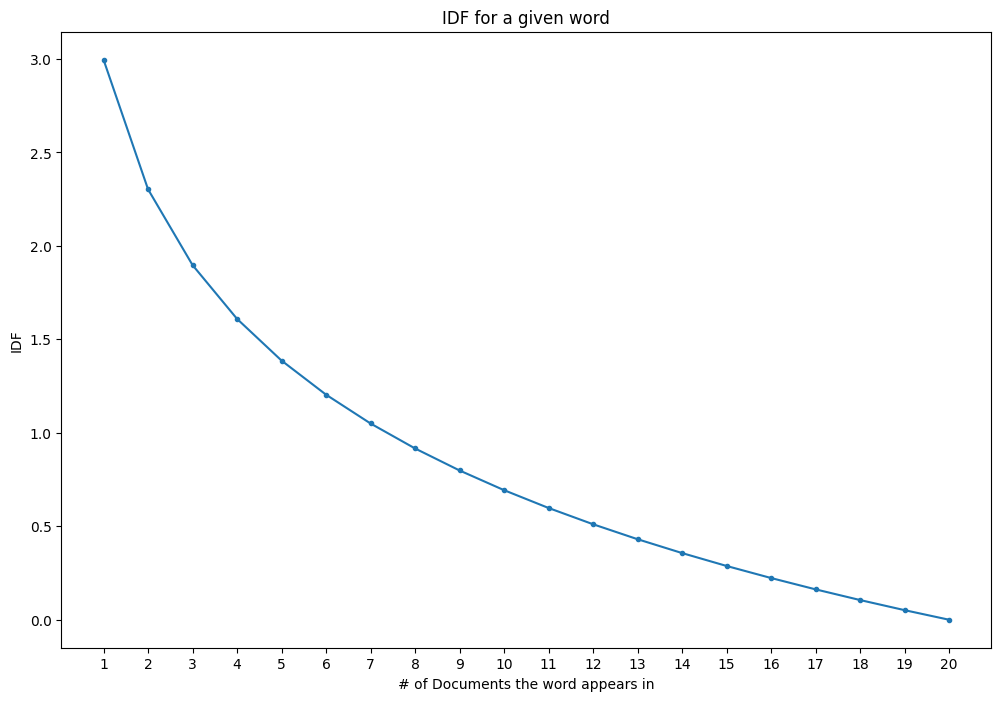

In [3]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')
plt.show()

#### Now let's walk through an example of calculating IDF for multiple words. We'll use a small example dataset.

#### First we'll prepare the data:

In [4]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': 'codeups data science program wa created in response to a '
            'percieved lack of data science talent and growing demand',
 'description': 'codeups data science program teach hand on skill using python '
                'and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


#### Then we can calculate the inverse document frequency metric for each word.

In [5]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0


#### A higher IDF means that a word provides more information. That is, it is more relevant within a single document.

#### ***IDF inputs***

##### The calculation for an individual IDF score requires a word and a set of documents.

### ***TF-IDF***

##### TF-IDF is simply the multiplication of the two metrics we've discussed above. Let's calculate an TF-IDF for all of the words and documents:

In [6]:
tfs = []

# We'll caclulate the tf-idf value for every word across every document

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False))

,word,doc,tf_idf
5,hand,description,0.250000
4,teach,description,0.250000
11,panda,description,0.250000
9,python,description,0.250000
8,using,description,0.250000
7,skill,description,0.250000
14,wa,context,0.176471
13,created,context,0.176471
11,response,context,0.176471
9,to,context,0.176471


## **TF-IDF with scikit-learn**

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x37 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

***We get back a sparse matrix, a matrix with more 0s than anything else. Numpy has a special type that makes some manipulations and operations faster on sparse matrices.***

***Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, and put everything in a dataframe. If our data were larger, the operation below might take much longer.***

In [8]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names_out())

,18,and,announced,codeup,codeups,created,data,demand,growing,hand,...,skill,talent,teach,that,they,thursday,to,using,wa,week
0,0.2578,0.000000,0.2578,0.2578,0.000000,0.000000,0.152261,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.2578,0.2578,0.2578,0.000000,0.000000,0.000000,0.2578
1,0.0000,0.250693,0.0000,0.0000,0.250693,0.000000,0.194686,0.000000,0.000000,0.329631,...,0.329631,0.000000,0.329631,0.0000,0.0000,0.0000,0.000000,0.329631,0.000000,0.0000
2,0.0000,0.194456,0.0000,0.0000,0.194456,0.255686,0.302025,0.255686,0.255686,0.000000,...,0.000000,0.255686,0.000000,0.0000,0.0000,0.0000,0.255686,0.000000,0.255686,0.0000


# Modeling

#### Now we'll use the computed TF-IDF values as features in a model. We'll take a look at the spam data set first.

#### Because of the way we are modeling the data, we have a lot of columns, and it is not uncommon to have more columns than rows. Also, our data is very imbalanced in the class distribution, that is, there are many more ham messages than spam messages.

#### Other than these considerations, we can treat this as a standard classification problem. We'll use logistic regression as an example:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from env import username, password, host

def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [12]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.55%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   107
spam          2   491
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.82      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457



In [13]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 96.59%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        965    37
spam         1   112
---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.75      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

